# Rotinas para a detecção das não-bijetividades

## Imports

In [1]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.insert(0,'..')
import lib.tf_levenberg_marquardt.levenberg_marquardt as lm
import tensorflow as tf
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers
from itertools import product
from time import time
from scipy.optimize import root
from functools import partial
from itertools import product
import polars as pl
from nn_utils import *

## Funções

In [2]:
def nmse_error(y, y_hat):
    nmse = 10*np.log10(
        np.sum(np.abs(y-y_hat)**2)/
        np.sum(np.abs(y)**2)
        )
    return nmse

In [3]:
def load_csv2numpy(p):
    return np.loadtxt(p, delimiter=',', dtype=np.float32, skiprows=1)

In [4]:
def z2n(n):
    return n if n<0 else None

In [5]:
def prep_data_y(y, M, My=1):
    a0 = np.abs(y)
    end = z2n(-M-1)
    abs = [a0[:end],]
    for m in range(My-1):
        end = z2n(-M+m)
        abs.append(a0[m+1:end])
    abs = np.array(abs).T
    return abs

In [6]:
def prep_data(x, M):
    a0 = np.abs(x)
    abs = []
    for m in range(M):
        abs.append(a0[M+m+1-M:m-M])
    abs.append(a0[M+1:])
    abs = np.array(abs).T

    p0 = np.angle(x)
    phase = []
    for m in range(M):
        phase.append(p0[M+m+1-M:m-M])
    phase.append(p0[M+1:])
    phase = np.array(phase).T
    
    delta = []
    for m in range(1,phase.shape[1]):
        delta.append(phase[:,m]-phase[:,m-1])
    delta = np.array(delta).T
    
    d_cos = np.cos(delta)
    d_sin = np.sin(delta)

    inputs = abs
    if M > 0:
        inputs = np.append(inputs, d_cos, axis=1)
        inputs = np.append(inputs, d_sin, axis=1)
    return inputs

In [7]:
def recuperar_data(s, x):
    y = s*np.exp(1j*np.angle(x))
    return y

In [8]:
def gerar_s(y, x):
    s = y*np.exp(-1j*np.angle(x))
    return s.real, s.imag

In [9]:
def normalize_data(x):
    return (x)/np.std(x)

In [10]:
def gen_model(M, HL, name, activation='tanh'):
    size_input = 1+3*(M)
    inputs = keras.Input(shape=(size_input,))
    hidden = layers.Dense(HL, activation=activation)(inputs)
    output = layers.Dense(1, activation='linear')(hidden)
    model = keras.Model(inputs=inputs, outputs=output, name=name)
    model = lm.ModelWrapper(model)
    model.call = tf.function(model.call)
    return model

In [11]:
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
        loss=lm.MeanSquaredError(),
        metrics=['accuracy','mse'],
        run_eargly=False)

In [12]:
def fit_model(model, epochs, inputs, s):
    history = model.fit(inputs, s, epochs=epochs, batch_size=128, verbose=0)
    return history

In [13]:
def run_model(x, model, M):
    inputs = prep_data(x, M)
    # Modificado por questões de performance, o model.predict acaba ficando sem o ganho de usar o tf.function no modelo
    s_hat_real = model[0](inputs).numpy().reshape(-1,)
    s_hat_imag = model[1](inputs).numpy().reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M+1:])
    return y_hat

In [14]:
def validation(model, x, y, M):
    y_hat = run_model(x, model, M)
    nmse = nmse_error(y[M+1:], y_hat)
    return nmse, y_hat

In [15]:
def find_best_M_HL(x, y, M_min=0, M_max=10, HL_min=1, HL_max=10):    
    best_M = 0
    best_model = None
    best_nmse = np.inf
    best_y_hat = None
    metaparams = product(range(M_min,M_max+1), range(HL_min,HL_max+1))
    for M, HL in metaparams:
        start = time()
        inputs = prep_data(x, M)
        s_real, s_imag = gerar_s(y[M+1:], x[M+1:])

        model_real = gen_model(M, HL, 'parte_real')
        model_imag = gen_model(M, HL, 'parte_imag')

        compile_model(model_real)
        compile_model(model_imag)
        his = [0,0]
        his[0] = fit_model(model_real, 1000, inputs, s_real)
        his[1] = fit_model(model_imag, 1000, inputs, s_imag)
        
        model = (model_real, model_imag)
        # nmse = validation_models(model_real, model_imag, inputs, x, y)
        nmse, y_hat = validation(model, x, y, M)
        end = time()
        if nmse < best_nmse:
            best_nmse = nmse
            best_model = model
            best_M = M
            best_y_hat = y_hat
            print('*** BEST ***')
            print(f'Shape:{inputs.shape[1]} M:{M} HL:{HL} nmse:{nmse} time:{end-start}')
    return best_model, best_M, best_y_hat, best_nmse, his

## Plot do PA

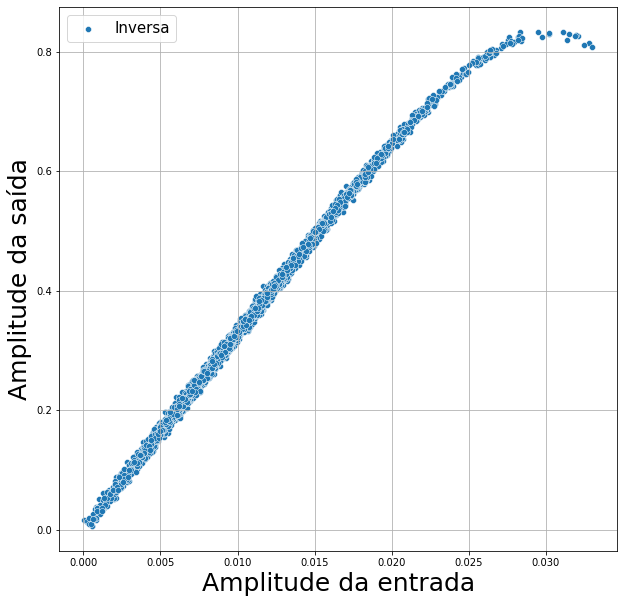

In [16]:
p = '../data/modeledcadence_extraction.csv'
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
#x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
#y = normalize_data(y)
y_abs = np.abs(y)

plt.figure(figsize=(10,10))
sns.scatterplot(x=x_abs, y=y_abs/max(y_abs*1.2), label='Inversa')
plt.grid()
plt.legend(fontsize=15, loc='upper left')
plt.ylabel('Amplitude da saída', size=25)
plt.xlabel('Amplitude da entrada', size=25)
plt.savefig('fig/modelo_pa.pdf', bbox_inches='tight')
plt.show()
plt.close()

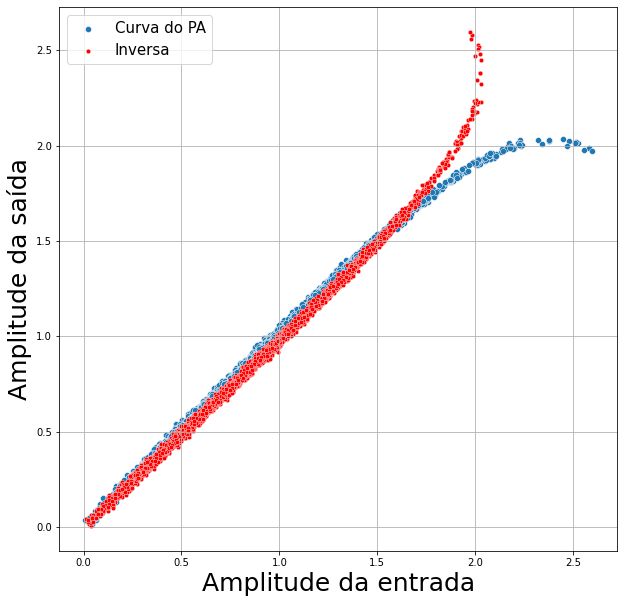

In [17]:
p = '../data/modeledcadence_extraction.csv'
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

plt.figure(figsize=(10,10))
sns.scatterplot(x=x_abs, y=y_abs, label='Curva do PA')
sns.scatterplot(x=y_abs, y=x_abs, label='Inversa', color='red', s=20)
plt.grid()
plt.legend(fontsize=15, loc='upper left')
plt.ylabel('Amplitude da saída', size=25)
plt.xlabel('Amplitude da entrada', size=25)
plt.show()
plt.close()

## Plot das inversas

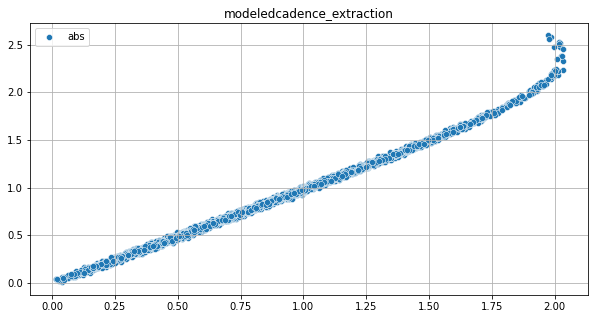

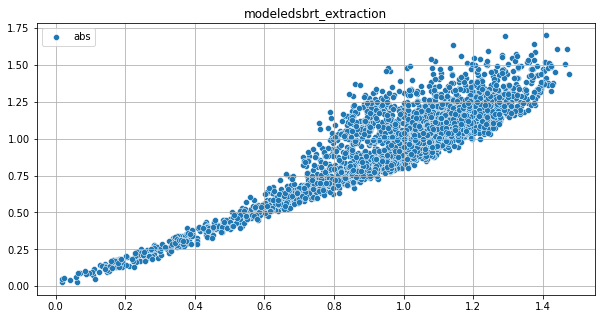

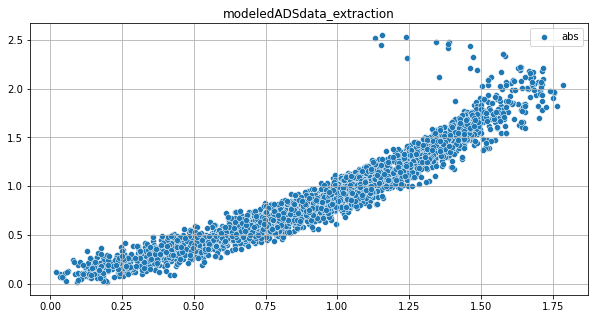

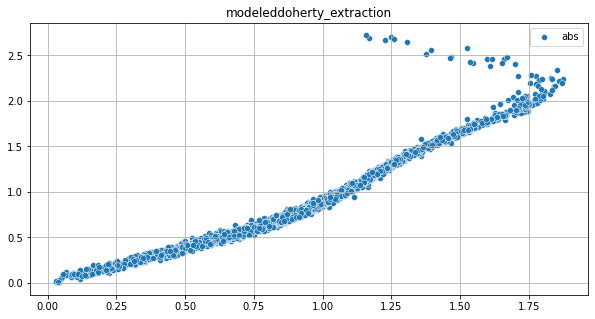

In [16]:
# plot inversa PA
for p in Path().glob('../data/*_extraction.csv'):
    data = load_csv2numpy(p)
 
    x = data[:, 2] + 1j*data[:, 3]
    x = normalize_data(x)
    x_abs = np.abs(x)

    y = data[:, 0] + 1j*data[:, 1]
    y = normalize_data(y)
    y_abs = np.abs(y)

    plt.figure(figsize=(10,5))
    sns.scatterplot(x=x_abs, y=y_abs, label='abs')
    plt.grid()
    plt.title(p.stem)
    plt.show()
    plt.close()

    # best_model, M = find_best_M_HL(x, y, M_min=3, M_max=20, HL_min=5, HL_max=20)
    '''
    pv = p.parent/p.parts[-1].replace('extraction', 'validation')
    data = load_csv2numpy(pv)

    x = data[:, 0] + 1j*data[:, 1]
    x = normalize_data(x)
    y = data[:, 2] + 1j*data[:, 3]
    y = normalize_data(y)

    nmse = validation(best_model, x, y, M)
    '''

## Treinamento da Rede Neural

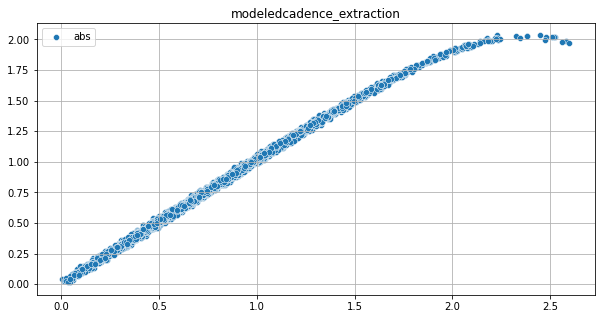

*** BEST ***
Shape:10 M:3 HL:7 nmse:-60.699944496154785 time:189.13501477241516
nmse - extraction: -60.699944496154785
nmse - validation: -42.30689525604248


In [18]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

plt.figure(figsize=(10,5))
ax = sns.scatterplot(x=x_abs, y=y_abs, label='abs')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

M = 3
HL = 7

model, M, y_hat, nmse, his = find_best_M_HL(x, y, M_min=M, M_max=M, HL_min=HL, HL_max=HL)
print(f'nmse - extraction: {nmse}')

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, _ = validation(model, x, y, M)
print(f'nmse - validation: {nmse}')

## Carregando Rede Neural

In [63]:
model = [0,0]
M = 3
HL = 7
model[0] = gen_model(M, HL, 'parte_real', activation='tanh')
model[1] = gen_model(M, HL, 'parte_imag', activation='tanh')

model[0].load_weights('./weights/modeledcadence_extraction_real2');
model[1].load_weights('./weights/modeledcadence_extraction_imag2');

model_PA = model
model_PA[0].summary()
model_PA[1].summary()

Model: "model_wrapper_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 parte_real (Functional)     (None, 1)                 85        
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
Model: "model_wrapper_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 parte_imag (Functional)     (None, 1)                 85        
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


## Validação do Modelo

nmse - extraction: -60.90199947357178


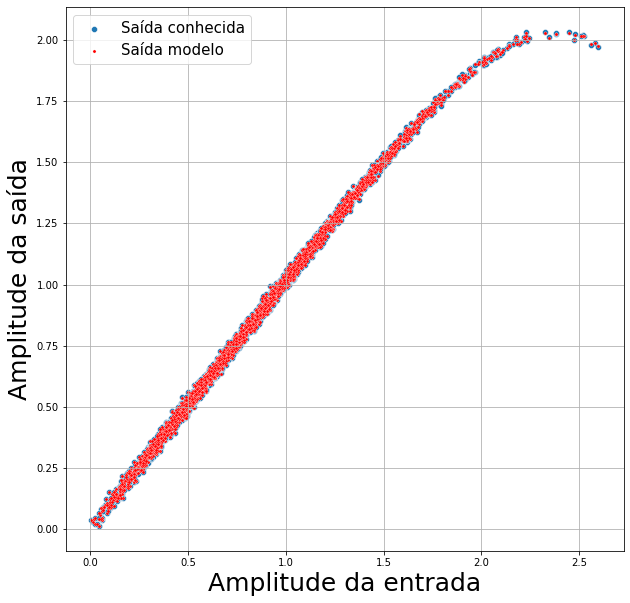

In [66]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)
x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model, x, y, M)
print(f'nmse - extraction: {nmse}')

plt.figure(figsize=(10,10))
sns.scatterplot(x=x_abs, y=y_abs, label='Saída conhecida')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='Saída modelo', s=10, color='red')
plt.grid()
#plt.title(f'Validação - NMSE: {nmse:.3f}')
plt.legend(fontsize=15, loc='upper left')
plt.ylabel('Amplitude da saída', size=25)
plt.xlabel('Amplitude da entrada', size=25)
plt.savefig('fig/extracao_pa.pdf', bbox_inches='tight')
plt.show()
plt.close()

nmse - validation: -42.87520408630371


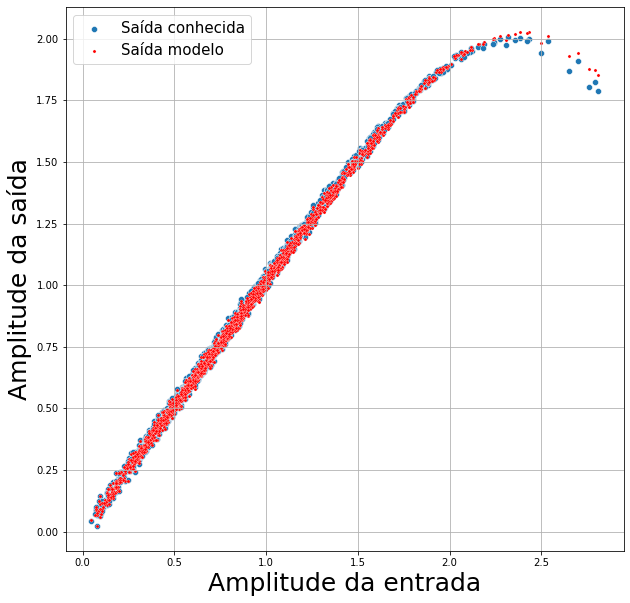

In [67]:
p = Path('../data/modeledcadence_validation.csv')
data = load_csv2numpy(p)
x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model, x, y, M)
print(f'nmse - validation: {nmse}')

plt.figure(figsize=(10,10))
sns.scatterplot(x=x_abs, y=y_abs, label='Saída conhecida')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='Saída modelo', s=10, color='red')
plt.grid()
#plt.title(f'Validação - NMSE: {nmse:.3f}')
plt.legend(fontsize=15, loc='upper left')
plt.ylabel('Amplitude da saída', size=25)
plt.xlabel('Amplitude da entrada', size=25)
plt.savefig('fig/validacao_pa.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Funções Problema Inverso

In [17]:
def inverse_problem(x, y, model, M, x_old, exp=False):
    if exp:
        x = np.array([x[0]*np.exp(1j*x[1])])
    else:
        x = np.array([x[0]+1j*x[1]])
    
    if np.abs(x) > 3:
        gama = np.abs(x)
    else:
        gama = 1
    x = np.concatenate([x_old, x])

    y_hat = run_model(x, model, M)

    y_real, y_imag = y_hat.real, y_hat.imag
    output = np.array([y.real - y_real, y.imag - y_imag]).reshape(-1,)
    output *= gama
    return output

In [18]:
def solve_inverse_problem(n, x, x_n, xs, x_abs, M, model, r_model, exp=True):
    if n<M+1:
        return

    #if x_abs[n] < 1:
    #    pass

    xt = x[n-M-1:n+1] # Valores de x para extrair o y0
    x_old = xt[:-1] # Valores de x antigos
    x_a = xt[-1].reshape(-1,) # Valor de x atual
    y0 = r_model(x=xt) # Extração do y0

    #print(f'inicia o problema inverso nº {n}')

    # Problema inverso
    i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old, exp=exp)
    res = []
    for i, x0 in enumerate(xs):
        res.append(root(i_problem, x0=x0))
        #print(f'{i}, ', end='')

    # Erro
    # print(f'x:   {x_a}')
    max_x = 2.4491508 # np.abs(x[np.abs(y).argmax()])
    results = dict()
    for i, x0 in enumerate(xs):
        x0 = x0[0]*np.exp(1j*x0[1]).reshape(-1,)
        new_x0 = (res[i].x[0]*np.exp(1j*res[i].x[1])).reshape(-1,)
        new_y0 = r_model(x=np.concatenate([x_old, new_x0]))
        error_y0 = nmse_error(y0, new_y0)
        error_x0 = nmse_error(x_a, new_x0)
        #print(f'x0{i}: {x0} -> {new_x0} -> {np.abs(new_x0)} -> {error_y0} -> {error_x0}')
        results[i] = {'NMSE ŷ': error_y0, 'NMSE x̂': error_x0, 'Região de x̂': 'Crescente' if np.abs(new_x0) <= max_x else 'Decrescente'}
    return results

In [19]:
def plot_errors(results, i, x0, ax):

    teste_x0 = [results[r][i] for r in results]
    ex0, ey0, regiao = list(zip(*[(k['NMSE x̂'], k['NMSE ŷ'], k['Região de x̂']) for k in teste_x0]))

    sns.scatterplot(x=ex0, y=ey0,
                    hue=regiao, palette={'Crescente':'#2CC8C8', 'Decrescente':'#FF9238'},
                    alpha=0.7,
                    ax=ax)

    ax.set(xlabel='NMSE x̂', ylabel='NMSE ŷ')
    ax.set_title(f'Valor Inicial {x0[0]}∠{x0[1]:.02f}')
    ax.grid()
    ax.set_xticks(np.arange(100, -250, -50))
    ax.set_yticks(np.arange(100, -250, -50))
    ax.set_xlim(-250, 50)
    ax.set_ylim(-250, 50)
    ax.legend(loc='upper left')

In [20]:
def gen_xs(amplitude):
    x01 = np.array([amplitude,0*2*np.pi/9]) # Chute inicial de x0
    x02 = np.array([amplitude,1*2*np.pi/9]) # Chute inicial de x0
    x03 = np.array([amplitude,2*2*np.pi/9]) # Chute inicial de x0
    x04 = np.array([amplitude,3*2*np.pi/9]) # Chute inicial de x0
    x05 = np.array([amplitude,4*2*np.pi/9]) # Chute inicial de x0
    x06 = np.array([amplitude,5*2*np.pi/9]) # Chute inicial de x0
    x07 = np.array([amplitude,6*2*np.pi/9]) # Chute inicial de x0
    x08 = np.array([amplitude,7*2*np.pi/9]) # Chute inicial de x0
    x09 = np.array([amplitude,8*2*np.pi/9]) # Chute inicial de x0
    return [x01, x02, x03, x04, x05, x06, x07, x08, x09]

In [21]:
def result_porcentagem(result):
    df_result = pl.DataFrame(result)
    # Não convergiu
    r1 = df_result.filter((pl.col('NMSE x̂') >= -75) & (pl.col('NMSE ŷ') >= -75)).shape[0]
    # Falso positivo
    r2 = df_result.filter((pl.col('NMSE x̂') >= -75) & (pl.col('NMSE ŷ') < -75)).shape[0]
    # Não ocorre
    r3 = df_result.filter((pl.col('NMSE x̂') < -75) & (pl.col('NMSE ŷ') >= -75)).shape[0]
    # Ponto correto
    r4 = df_result.filter((pl.col('NMSE x̂') < -75) & (pl.col('NMSE ŷ') < -75)).shape[0]
    # Total
    total = df_result.shape[0]
    print(f'Não convergiu: {r1/total*100:.2f}%, Falso positivo: {r2/total*100:.2f}%, Ponto correto: {r4/total*100:.2f}%')
    return r1/total, r2/total, r4/total

In [22]:
def show_results(results, xs):
    results_array = []
    for i, _ in enumerate(xs):
        results_n = [results[r][i] for r in results]
        results_array.append(result_porcentagem(results_n))
    print('Média')
    print(''.join(map(lambda x: f'{x:0.2f}% ',np.array(results_array).mean(axis=0)*100)))

## Problema Inverso Todos

In [23]:
# Load data
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)
x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

In [44]:
r_model = partial(run_model, model=model, M=M)
xs = gen_xs(0.5)
results_fa05 = dict()
for n, x_n in enumerate(x):
    if (result := solve_inverse_problem(n, x, x_n, xs, x_abs, M, model, r_model, exp=True)):
        results_fa05[n] = result

KeyboardInterrupt: 

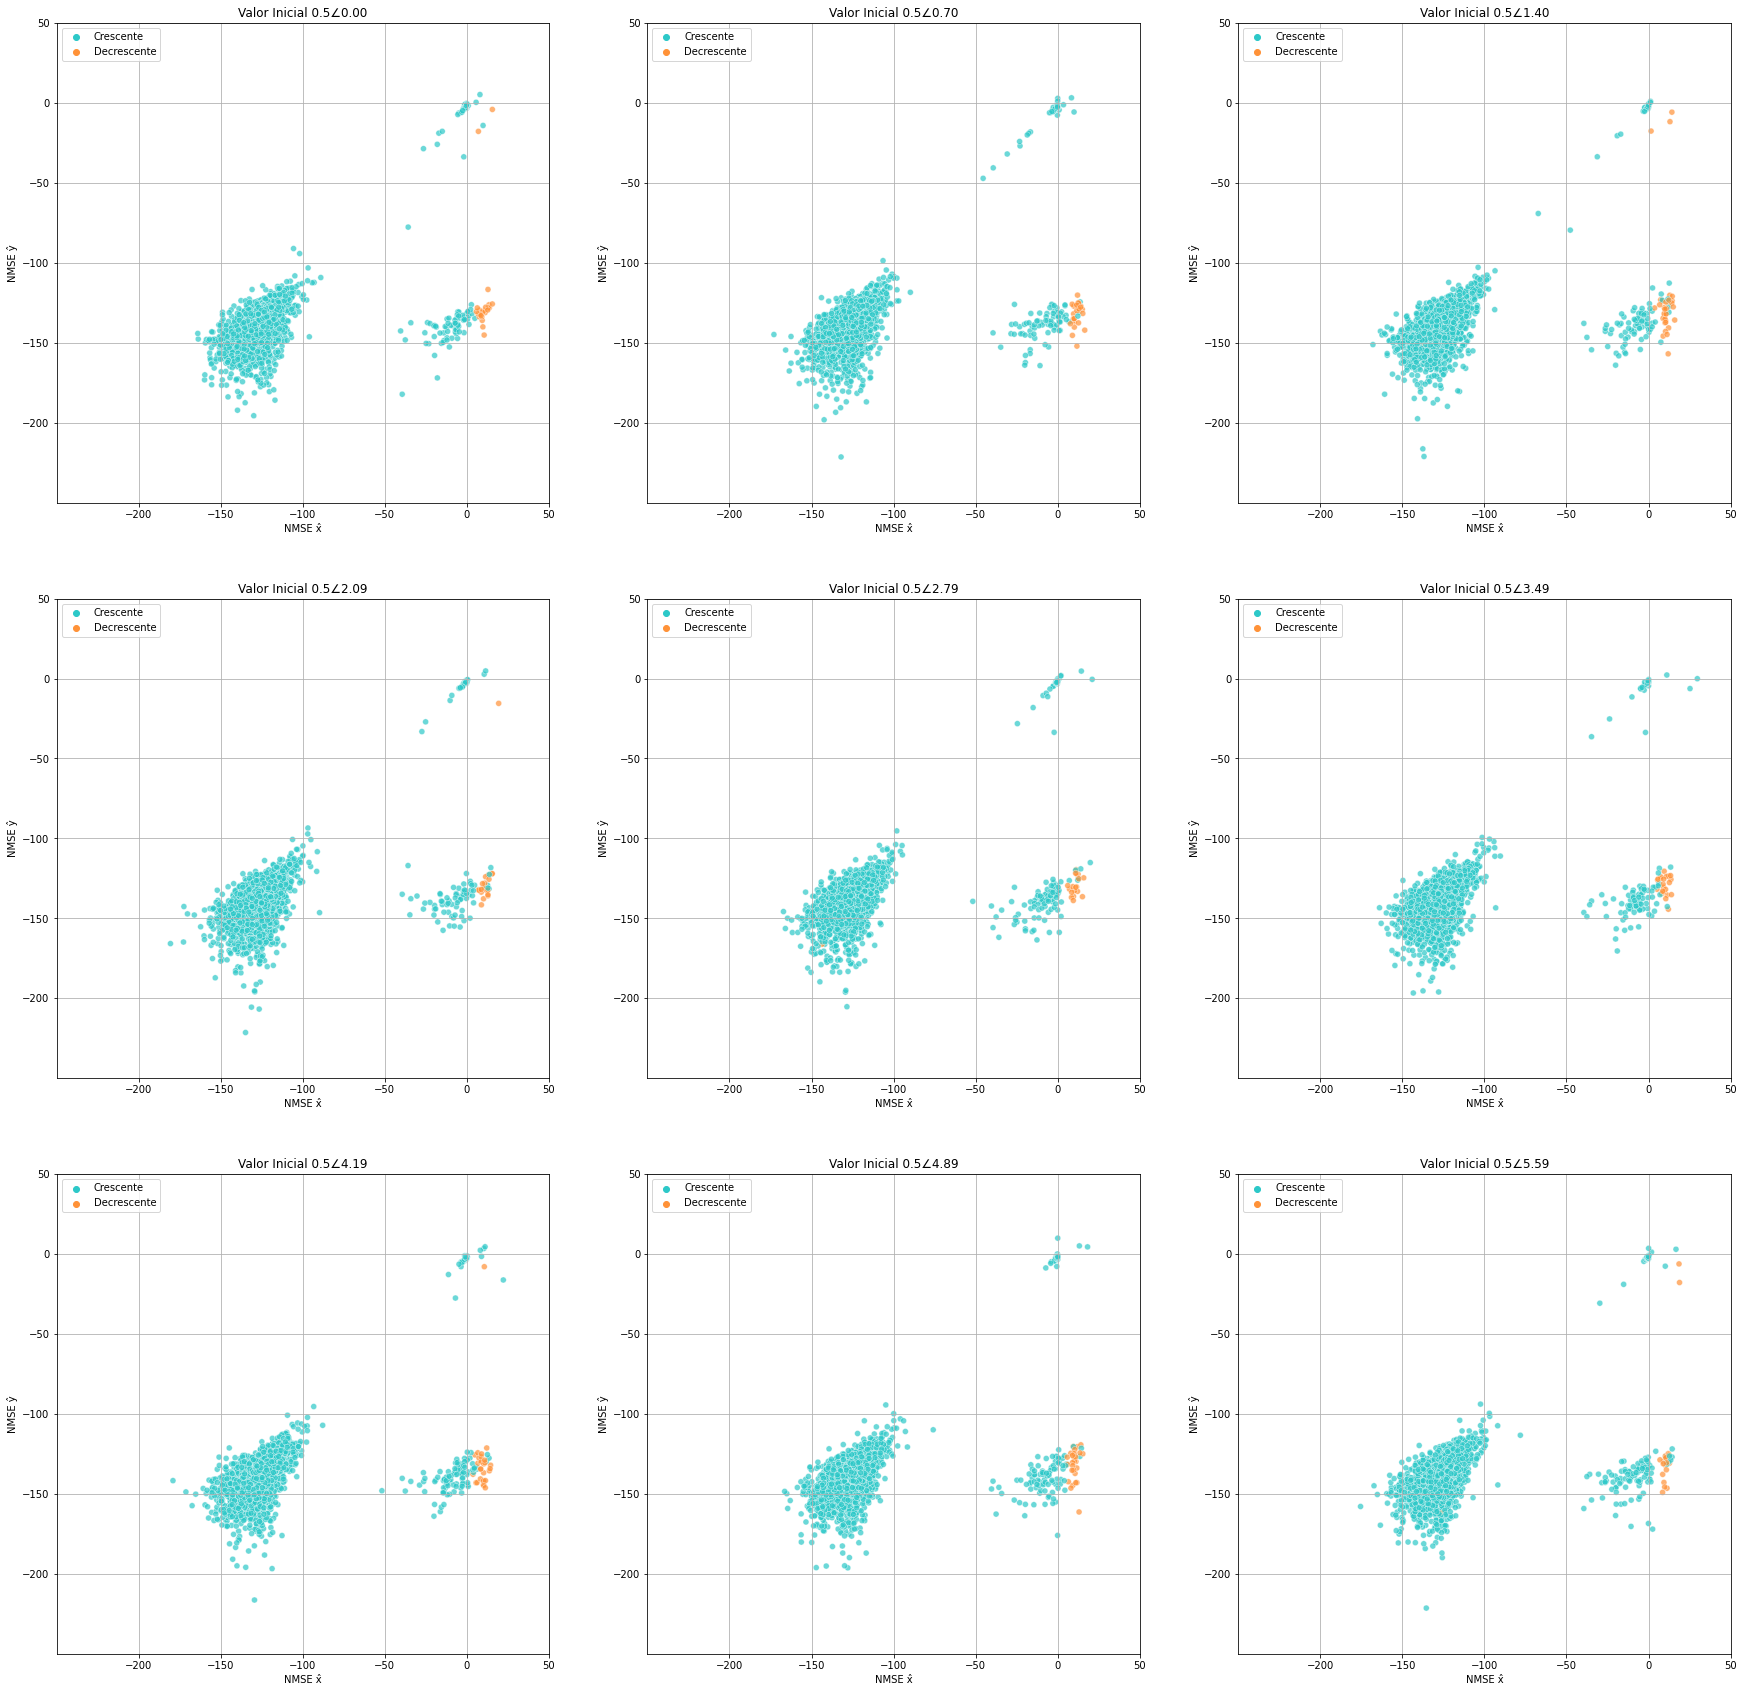

In [ ]:
f, axes = plt.subplots(3,3, figsize=(30,30))
for i, (x0, ax) in enumerate(zip(xs, axes.flatten())):
    plot_errors(results_fa05, i, x0, ax)

plt.show()
plt.close()

In [331]:
show_results(results_fa05, xs)

Não convergiu: 2.14%, Falso positivo: 3.14%, Ponto correto: 94.72%
Não convergiu: 1.74%, Falso positivo: 3.51%, Ponto correto: 94.76%
Não convergiu: 1.30%, Falso positivo: 3.71%, Ponto correto: 94.99%
Não convergiu: 1.47%, Falso positivo: 3.04%, Ponto correto: 95.49%
Não convergiu: 1.27%, Falso positivo: 3.67%, Ponto correto: 95.06%
Não convergiu: 1.34%, Falso positivo: 3.27%, Ponto correto: 95.39%
Não convergiu: 1.47%, Falso positivo: 4.18%, Ponto correto: 94.36%
Não convergiu: 1.17%, Falso positivo: 3.97%, Ponto correto: 94.86%
Não convergiu: 1.27%, Falso positivo: 4.04%, Ponto correto: 94.69%
Média
1.46% 3.61% 94.92% 


In [ ]:
r_model = partial(run_model, model=model, M=M)
xs = gen_xs(2.5)

results_fa25 = dict()
for n, x_n in enumerate(x):
    if (result := solve_inverse_problem(n, x, x_n, xs, x_abs, M, model, r_model, exp=True)):
        results_fa25[n] = result

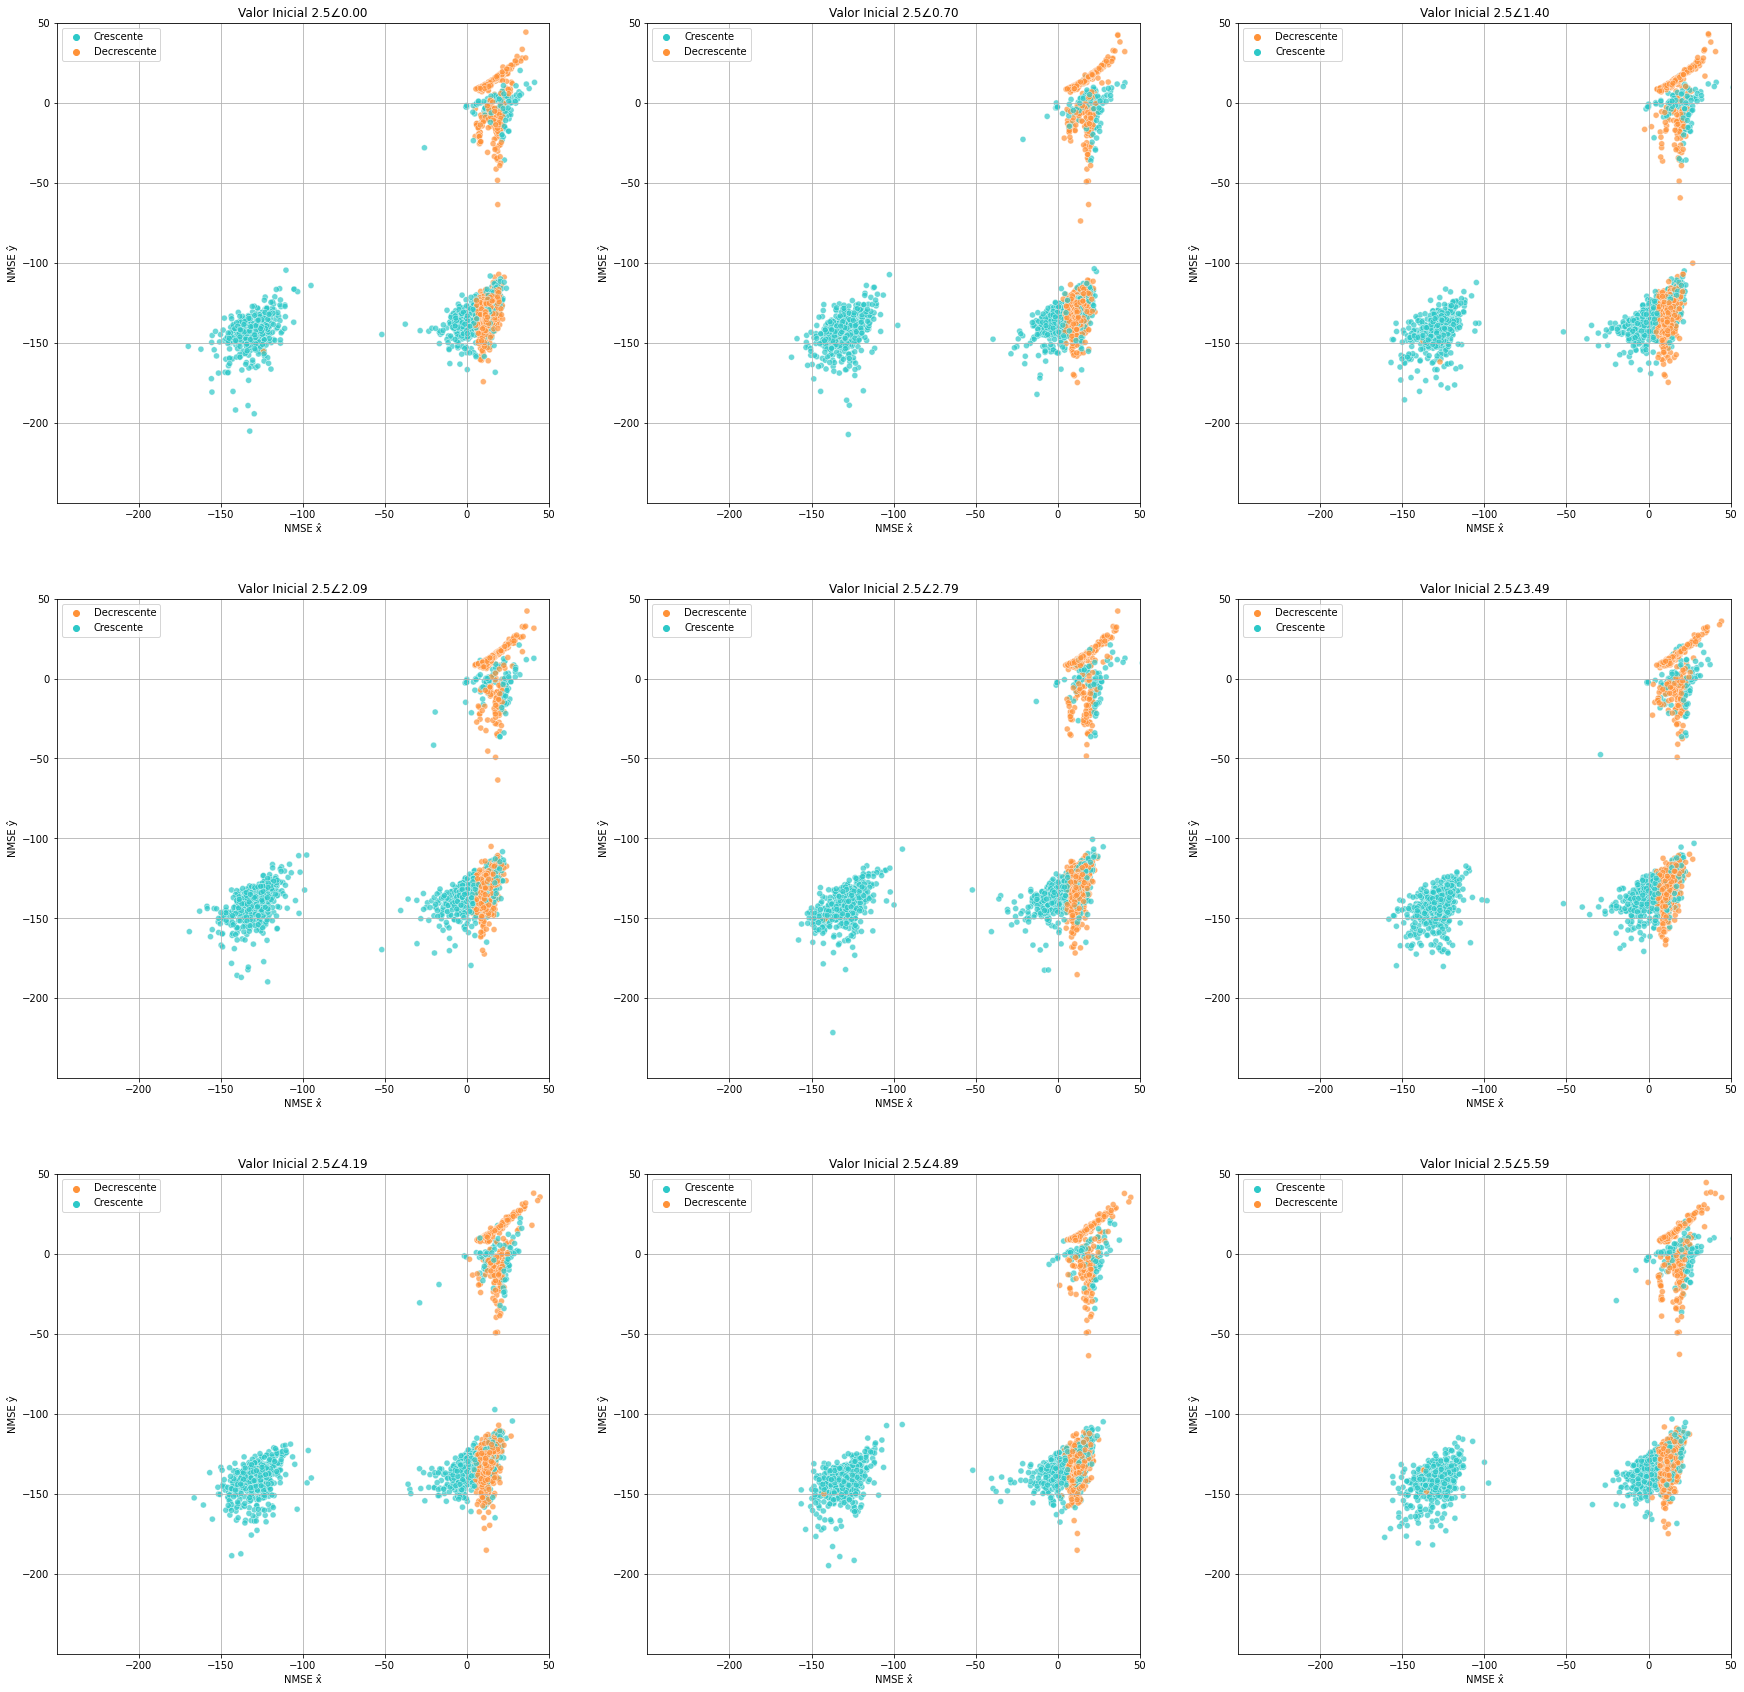

In [69]:
xs = gen_xs(2.5)
f, axes = plt.subplots(3,3, figsize=(30,30))
for i, (x0, ax) in enumerate(zip(xs, axes.flatten())):
    plot_errors(results_fa25, i, x0, ax)

plt.show()
plt.close()

In [332]:
show_results(results_fa25, xs)

Não convergiu: 16.70%, Falso positivo: 65.93%, Ponto correto: 17.37%
Não convergiu: 15.36%, Falso positivo: 67.57%, Ponto correto: 17.07%
Não convergiu: 15.76%, Falso positivo: 67.70%, Ponto correto: 16.53%
Não convergiu: 17.33%, Falso positivo: 65.36%, Ponto correto: 17.30%
Não convergiu: 16.83%, Falso positivo: 64.20%, Ponto correto: 18.97%
Não convergiu: 17.74%, Falso positivo: 63.93%, Ponto correto: 18.34%
Não convergiu: 16.13%, Falso positivo: 64.60%, Ponto correto: 19.27%
Não convergiu: 14.96%, Falso positivo: 66.30%, Ponto correto: 18.74%
Não convergiu: 15.90%, Falso positivo: 64.36%, Ponto correto: 19.74%
Média
16.30% 65.55% 18.15% 


## Figura Única do Problema Inverso

None
None
None
None


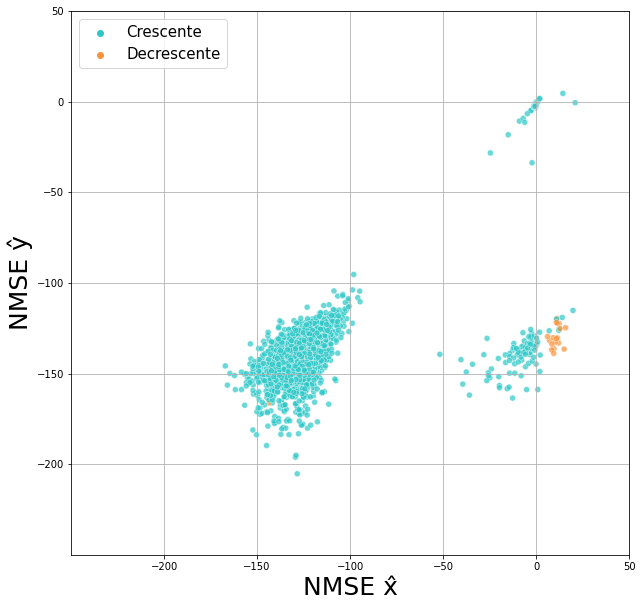

In [48]:
r_model = partial(run_model, model=model, M=M)
xs = gen_xs(0.5)[4:5]
results_fa05 = dict()
for n, x_n in enumerate(x):
    if (result := solve_inverse_problem(n, x, x_n, xs, x_abs, M, model, r_model, exp=True)):
        results_fa05[n] = result
    else:
        print(result)

plt.figure(figsize=(10,10))

x0 = xs[0]
teste_x0 = [r[0] for r in results_fa05.values()]
ex0, ey0, regiao = list(zip(*[(k['NMSE x̂'], k['NMSE ŷ'], k['Região de x̂']) for k in teste_x0]))

ax = sns.scatterplot(x=ex0, y=ey0,
                hue=regiao, palette={'Crescente':'#2CC8C8', 'Decrescente':'#FF9238'},
                alpha=0.7)

#plt.title(f'Valor Inicial {x0[0]}∠{x0[1]:.02f}')

ax.set_xticks(np.arange(100, -250, -50))
ax.set_yticks(np.arange(100, -250, -50))
ax.set_xlim(-250, 50)
ax.set_ylim(-250, 50)

plt.legend(fontsize=15, loc='upper left')
plt.xlabel('NMSE x̂', size=25)
plt.ylabel('NMSE ŷ', size=25)
plt.grid()
plt.savefig('fig/erros_05.pdf', bbox_inches='tight')
plt.show()
plt.close()

None
None
None
None


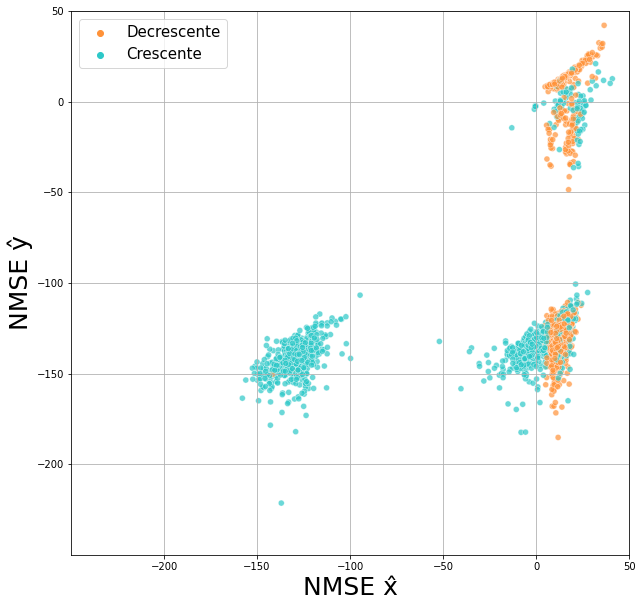

In [47]:
r_model = partial(run_model, model=model, M=M)
xs = gen_xs(2.5)[4:5]
results_fa05 = dict()
for n, x_n in enumerate(x):
    if (result := solve_inverse_problem(n, x, x_n, xs, x_abs, M, model, r_model, exp=True)):
        results_fa05[n] = result
    else:
        print(result)

plt.figure(figsize=(10,10))

x0 = xs[0]
teste_x0 = [r[0] for r in results_fa05.values()]
ex0, ey0, regiao = list(zip(*[(k['NMSE x̂'], k['NMSE ŷ'], k['Região de x̂']) for k in teste_x0]))

ax = sns.scatterplot(x=ex0, y=ey0,
                hue=regiao, palette={'Crescente':'#2CC8C8', 'Decrescente':'#FF9238'},
                alpha=0.7)

#plt.title(f'Valor Inicial {x0[0]}∠{x0[1]:.02f}')

ax.set_xticks(np.arange(100, -250, -50))
ax.set_yticks(np.arange(100, -250, -50))
ax.set_xlim(-250, 50)
ax.set_ylim(-250, 50)

plt.legend(fontsize=15, loc='upper left')
plt.xlabel('NMSE x̂', size=25)
plt.ylabel('NMSE ŷ', size=25)
plt.grid()
plt.savefig('fig/erros_25.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Continuidade do modelo em NN

In [29]:
# Teste de curva
r_model = partial(run_model, model=model, M=M)
n = 342
x_old = x[n-M-1:n] # Valores de x antigos
ylist = []
xlist = []
for amplitude in range(1,300,1):
    amplitude = amplitude/100
    x0 = amplitude*np.exp(1j*np.pi/4).reshape(-1,)
    y0 = r_model(x=np.concatenate([x_old, x0])) # Extração do y0
    xlist.append(x0)
    ylist.append(y0)
mapping = ['Mapeadas' if np.abs(x_)<=np.abs(x.max()) else 'Não mapeadas' for x_ in xlist]

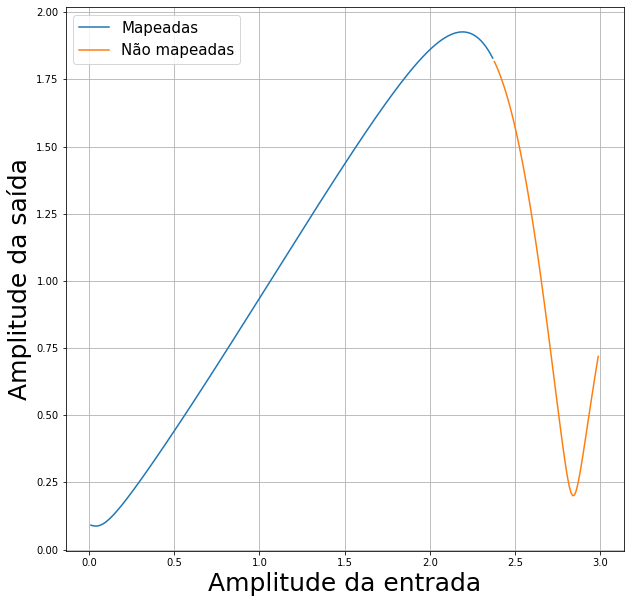

In [46]:
plt.figure(figsize=(10,10))
xlist = np.array(xlist).reshape(-1,)
ylist = np.array(ylist).reshape(-1,)
sns.lineplot(x=np.abs(xlist), y=np.abs(ylist), color='red', hue=mapping)
#plt.title(f'Continuidade do modelo para entradas não mapeadas para n={n}')
plt.legend(fontsize=15, loc='upper left')
plt.ylabel('Amplitude da saída', size=25)
plt.xlabel('Amplitude da entrada', size=25)
plt.grid()
plt.savefig('fig/continuidade_pa.pdf', bbox_inches='tight')
plt.show()
plt.close()

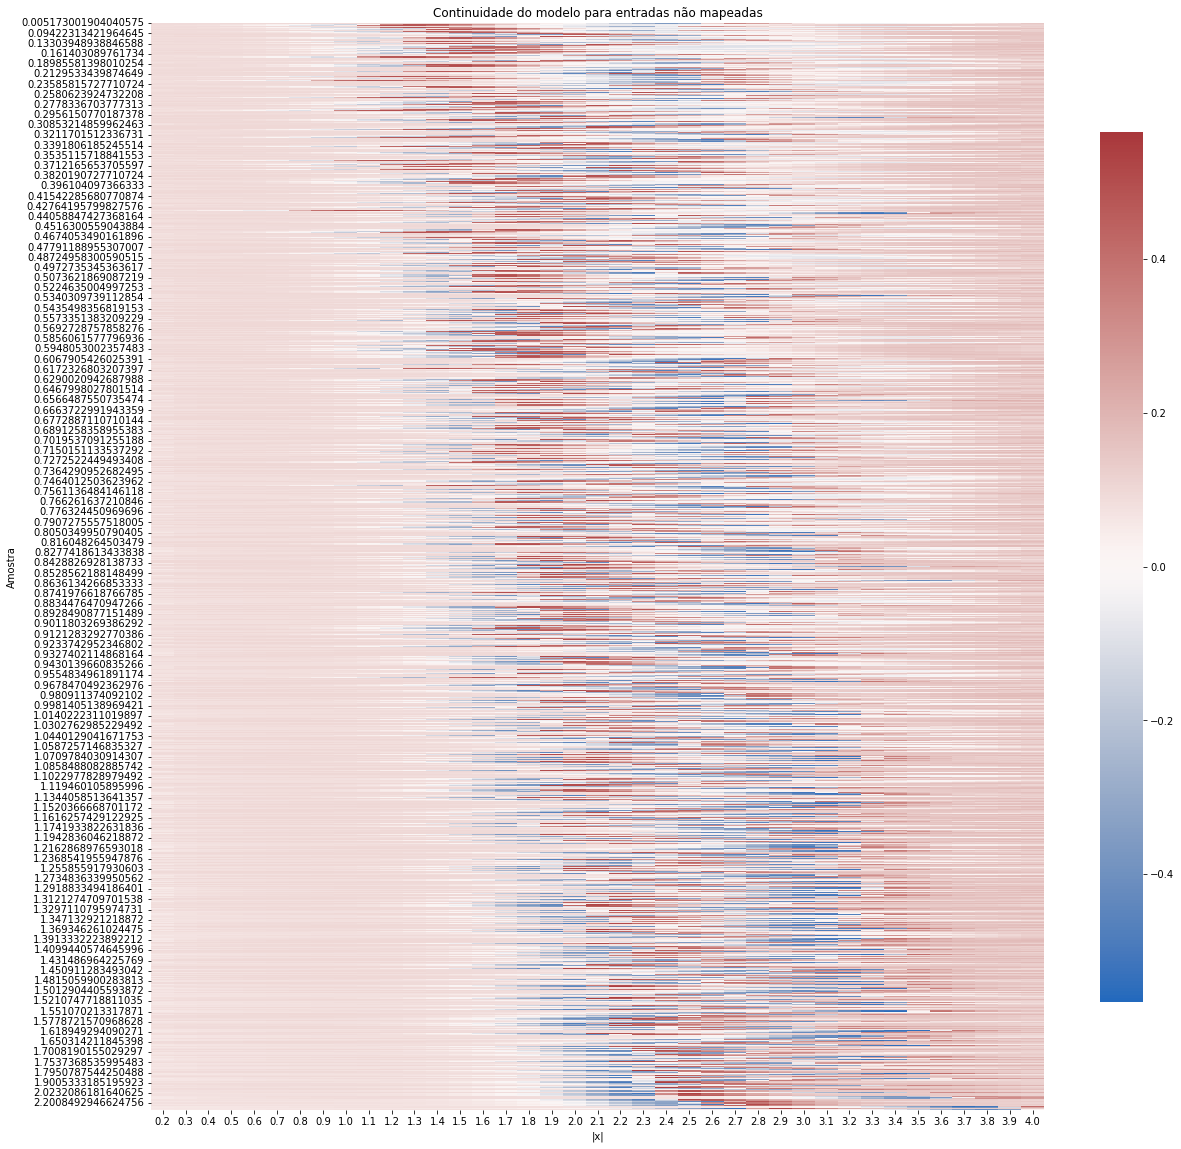

In [259]:
# Teste de curva
r_model = partial(run_model, model=model, M=M)
nlist = range(10,2998)
alist = range(1,51,1)
coordlist = product(nlist, alist)

z_list = []
x_list = []
y_list = []

for amostra, abs in coordlist:
    x_old = x[amostra-M-1:amostra] # Valores de x antigos
    abs = abs/10
    x0 = abs*np.exp(1j*np.pi/4).reshape(-1,)
    y0 = r_model(x=np.concatenate([x_old, x0])) # Extração do y0

    x_list.append(abs)
    y_list.append(np.abs(x[amostra]))
    z_list.append(y0)

y_list = np.array(y_list).reshape(-1,)
x_list = np.array(x_list).reshape(-1,)
z_list = np.abs(np.array(z_list)).reshape(-1,)

#mapping = ['Mapeadas' if np.abs(x_)<=np.abs(x.max()) else 'Não mapeadas' for x_ in xlist]
df_teste = pl.DataFrame({'x': x_list[1:], 'y': y_list[1:], 'z': np.diff(z_list)})
plt.figure(figsize=(20,20))

#sns.heatmap(x=np.abs(x_list), y=np.abs(y_list), hue=np.abs(z_list), cmap="Blues")
df_pandas_teste = df_teste.to_pandas().pivot(index='y', columns='x', values='z').iloc[:,1:40]
vmax = df_pandas_teste.abs().max().max()
sns.heatmap(data=df_pandas_teste, cmap="vlag", vmin=-vmax, vmax=vmax, cbar_kws={"shrink": .8})
plt.title(f'Continuidade do modelo para entradas não mapeadas')
plt.xlabel('|x|')
plt.ylabel('Amostra')
plt.show()
plt.close()

## Mesmo x para diferentes memórias

In [24]:
# Teste de curva
r_model = partial(run_model, model=model, M=M)
x0 = 1.5*np.exp(1j*np.pi/4).reshape(-1,)
ylist = []
tlist = []
for t in range(10,x.shape[0],1):
    x_old = x[t-M-1:t] # Valores de x antigos
    y0 = r_model(x=np.concatenate([x_old, x0])) # Extração do y0
    tlist.append(t)
    ylist.append(y0)

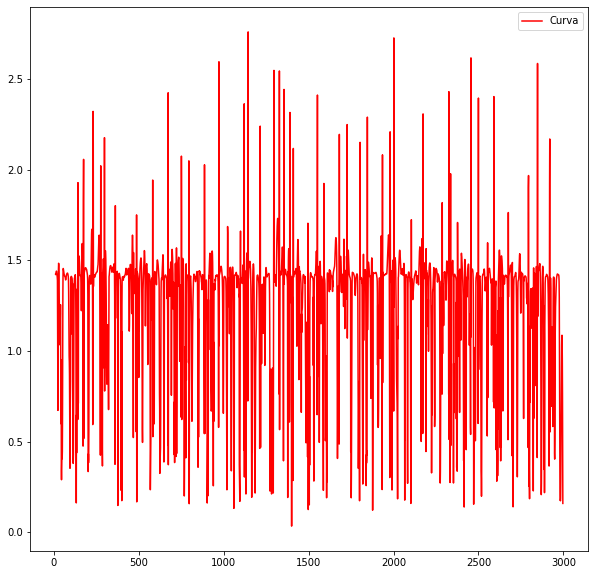

In [25]:
plt.figure(figsize=(10,10))
tlist = np.array(tlist).reshape(-1,)
ylist = np.array(ylist).reshape(-1,)
sns.lineplot(x=np.abs(tlist), y=np.abs(ylist), color='red', label='Curva')
plt.show()
plt.close()

## Efeito da entrada para o problema inverso

In [31]:
r_model = partial(run_model, model=model, M=M)
n = 2036
x_n = x[n]
x_old = x[n-M-1:n]
x_a = x[n].reshape(-1,)
xt = x[n-M-1:n+1] # Valores de x para extrair o y0
y0 = r_model(x=xt) # Extração do y0
i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old)

values = np.array(list(product(range(30,-30,-1), range(-30,30,1)))).reshape(-1,2)/10
values_exp = np.array(list(product(range(0,60,1), range(0,360,6)))).reshape(-1,2)/20
values_exp[:,1] = values_exp[:,1]*np.pi/9

### Real e imaginário

In [32]:
res = []
for i, x0 in enumerate(values):
    res.append(root(i_problem, x0=x0))

In [33]:
x0s = [r.x for r in res]
e0s = [r.fun for r in res]
a0s = [x[0]+1j*x[1] for x in x0s]
a0s = np.abs(np.array(a0s)).reshape(-1,1)
e0s = (np.sum(np.array(e0s)**2, axis=1)**0.5).reshape(-1,1)
t0s = np.where(e0s<0.1, a0s, 0)
v0s = np.concatenate([values, a0s, e0s, t0s], axis=1)
dfv = pl.DataFrame(v0s, columns=['real', 'imag', 'abs', 'erro', 'teste'])

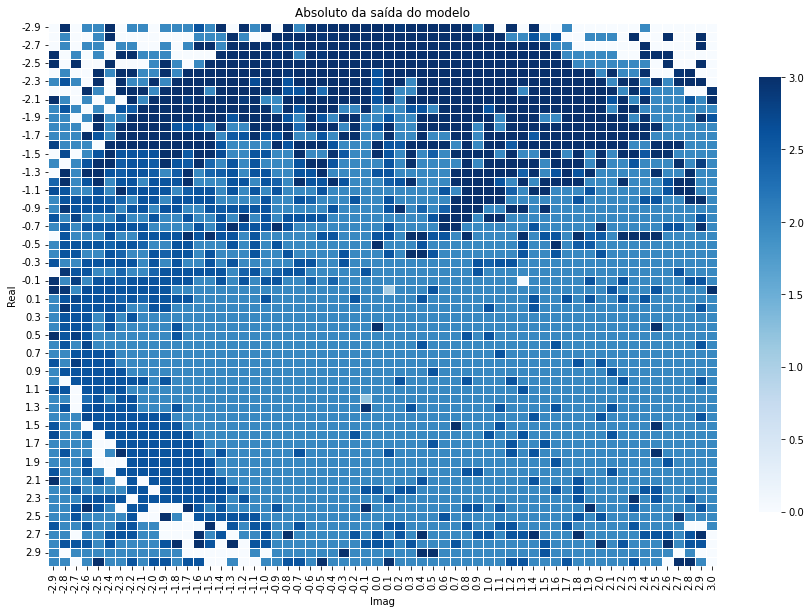

In [34]:
dfpdv = dfv[['real', 'imag', 'abs']].to_pandas()
dfpdv.set_index(['real', 'imag'], inplace=True)
dfunstack = dfpdv.unstack()
plt.figure(figsize=(15,10))
sns.heatmap(dfunstack, cmap="Blues", vmin=0, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
plt.xticks(np.arange(60) + .5, labels=dfunstack.index)
plt.xlabel('Imag')
plt.ylabel('Real')
plt.title('Absoluto da saída do modelo')
plt.savefig('fig/calor_todos.pdf')
plt.show()
plt.close()

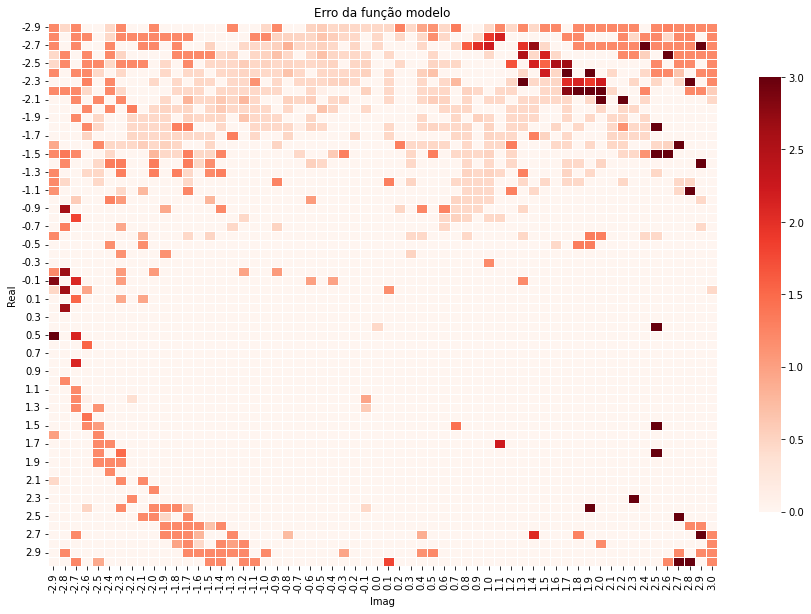

In [144]:
dfpdv = dfv[['real', 'imag', 'erro']].to_pandas()
dfpdv.set_index(['real', 'imag'], inplace=True)
dfunstack = dfpdv.unstack()
plt.figure(figsize=(15,10))
sns.heatmap(dfunstack, cmap="Reds", vmin=0, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
plt.xticks(np.arange(60) + .5, labels=dfunstack.index)
plt.xlabel('Imag')
plt.ylabel('Real')
plt.title('Erro da função modelo')
plt.show()
plt.close()

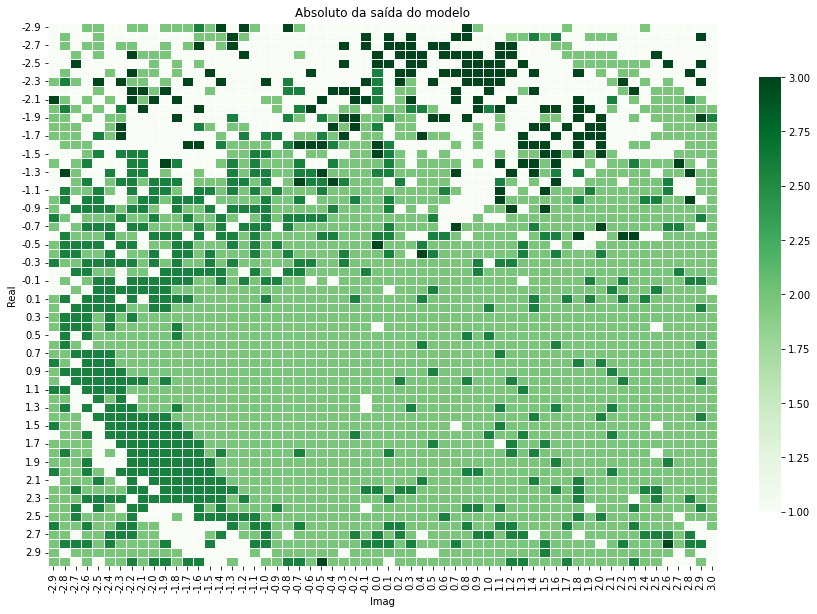

In [145]:
dfpdv = dfv[['real', 'imag', 'teste']].to_pandas()
dfpdv.set_index(['real', 'imag'], inplace=True)
dfunstack = dfpdv.unstack()
plt.figure(figsize=(15,10))
sns.heatmap(dfunstack, cmap="Greens", vmin=1, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
plt.xticks(np.arange(60) + .5, labels=dfunstack.index)
plt.xlabel('Imag')
plt.ylabel('Real')
plt.title('Absoluto da saída do modelo')
plt.show()
plt.close()

### Amplitude e Fase

In [35]:
res = []
for i, x0 in enumerate(values_exp):
    x0 = x0[0]*np.exp(1j*x0[1])
    x0 = np.array([x0.real, x0.imag])
    res.append(root(i_problem, x0=x0))

In [36]:
x0s = [r.x for r in res]
e0s = [r.fun for r in res]
a0s = [x[0]+1j*x[1] for x in x0s]
a0s = np.abs(np.array(a0s)).reshape(-1,1)
e0s = (np.sum(np.array(e0s)**2, axis=1)**0.5).reshape(-1,1)
t0s = np.where(e0s<0.1, a0s, 0)
v0s = np.concatenate([values_exp.round(3), a0s, e0s, t0s], axis=1)
dfv = pl.DataFrame(v0s, columns=['modulo', 'angulo', 'abs', 'erro', 'teste'])

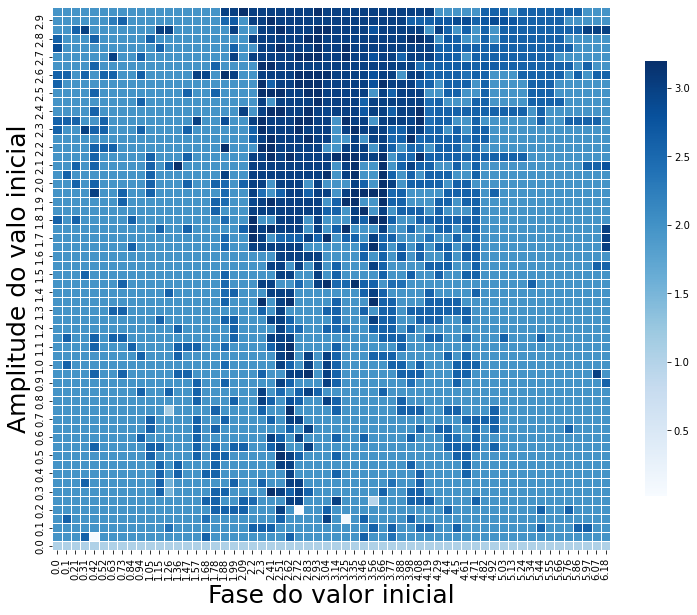

In [43]:
dfpdv = dfv[['modulo', 'angulo', 'abs']].to_pandas()
dfunstack = dfpdv.set_index(['modulo', 'angulo']).unstack()
dfpdv.set_index(['angulo','modulo'], inplace=True)
dfunstack2 = dfpdv.unstack()
plt.figure(figsize=(12.5,10))
ax = sns.heatmap(dfunstack, cmap="Blues", linewidth=1, cbar_kws={"shrink": .8})
ax.invert_yaxis()
plt.xticks(np.arange(60) + .5, labels=np.round(dfunstack2.index, decimals=2))
plt.xlabel('Fase do valor inicial', size=25)
plt.ylabel('Amplitude do valo inicial', size=25)
#plt.title('Amplitude do valor encontrado')
plt.savefig('fig/calor_todos.pdf', bbox_inches='tight')
plt.show()
plt.close()

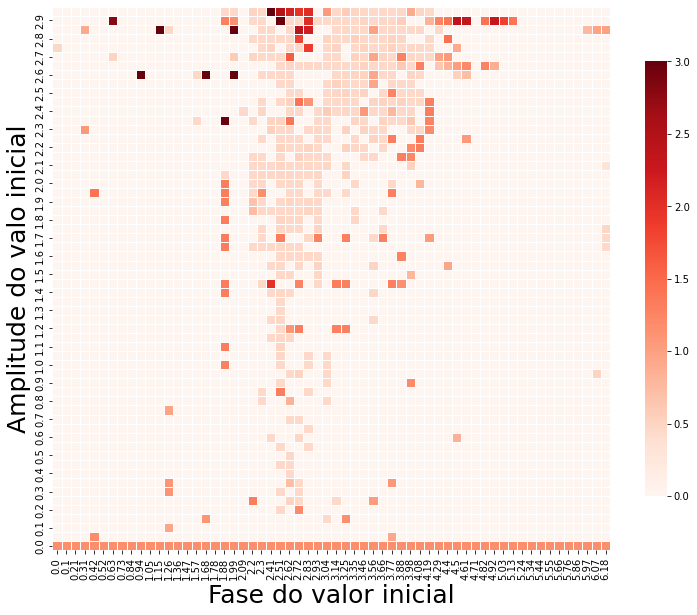

In [44]:
dfpdv = dfv[['modulo', 'angulo', 'erro']].to_pandas()
dfunstack = dfpdv.set_index(['modulo', 'angulo']).unstack()
dfpdv.set_index(['angulo','modulo'], inplace=True)
dfunstack2 = dfpdv.unstack()
plt.figure(figsize=(12.5,10))
ax = sns.heatmap(dfunstack, cmap="Reds", vmin=0, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
ax.invert_yaxis()
plt.xticks(np.arange(60) + .5, labels=np.round(dfunstack2.index, decimals=2))
plt.xlabel('Fase do valor inicial', size=25)
plt.ylabel('Amplitude do valo inicial', size=25)
#plt.title('Erro do valor encontrado')
plt.savefig('fig/calor_erro.pdf', bbox_inches='tight')
plt.show()
plt.close()

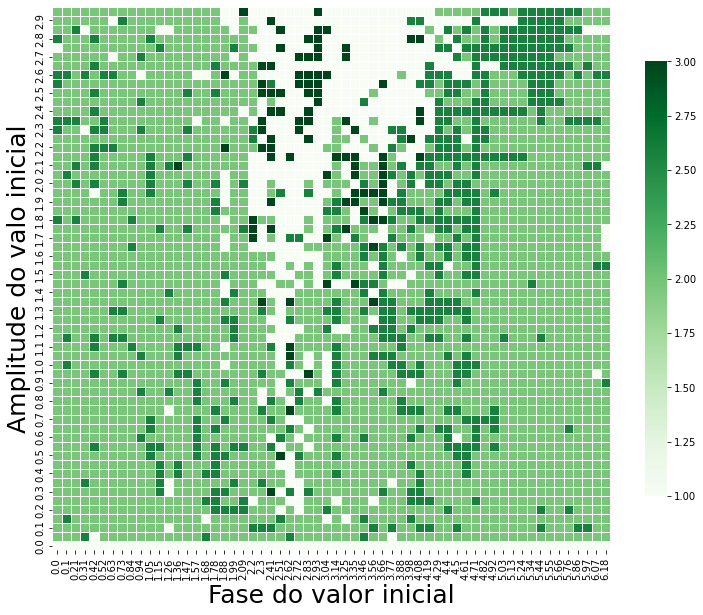

In [45]:
dfpdv = dfv[['modulo', 'angulo', 'teste']].to_pandas()
dfunstack = dfpdv.set_index(['modulo', 'angulo']).unstack()
dfpdv.set_index(['angulo','modulo'], inplace=True)
dfunstack2 = dfpdv.unstack()
plt.figure(figsize=(12.5,10))
ax = sns.heatmap(dfunstack, cmap="Greens", vmin=1, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
ax.invert_yaxis()
plt.xticks(np.arange(60) + .5, labels=np.round(dfunstack2.index, decimals=2))
plt.xlabel('Fase do valor inicial', size=25)
plt.ylabel('Amplitude do valo inicial', size=25)
#plt.title('Amplitude do valor encontrado')
plt.savefig('fig/calor_converge.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Treinamento da inversa

In [55]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 2] + 1j*data[:, 3]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)
y_abs = np.abs(y)

print(y_abs.max())
print(x_abs.max())

M = 3
HL = 7

model_Inv, M, y_hat, nmse, his = find_best_M_HL(x, y, M_min=M, M_max=M, HL_min=HL, HL_max=HL)
print(f'nmse - extraction: {nmse}')


2.5961926
2.0323806
*** BEST ***
Shape:10 M:3 HL:7 nmse:-50.486512184143066 time:188.74948740005493
nmse - extraction: -50.486512184143066


In [56]:
pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

x = data[:, 2] + 1j*data[:, 3]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)
y_abs = np.abs(y)

print(y_abs.max())
print(x_abs.max())

nmse, y_hat = validation(model_Inv, x, y, M)
print(f'nmse - validation: {nmse}')

2.810668
2.0061333
nmse - validation: -25.384409427642822


Validação - NMSE: -25.384


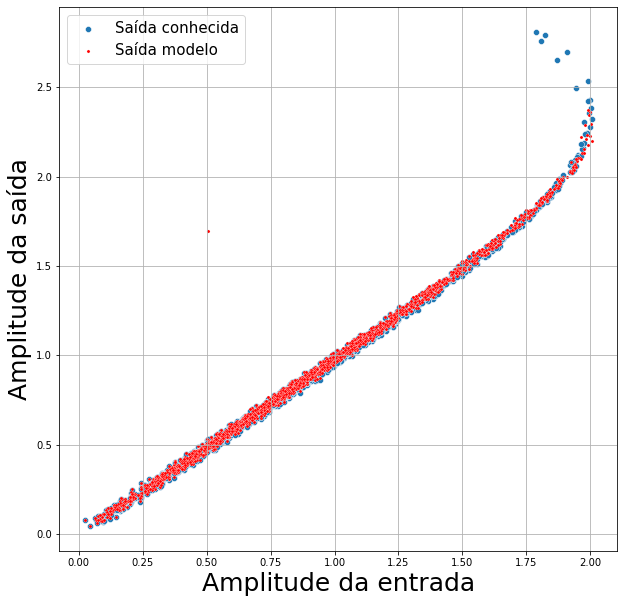

In [57]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=x_abs, y=y_abs, label='Saída conhecida')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='Saída modelo', s=10, color='red')
plt.grid()
print(f'Validação - NMSE: {nmse:.3f}')
plt.legend(fontsize=15, loc='upper left')
plt.ylabel('Amplitude da saída', size=25)
plt.xlabel('Amplitude da entrada', size=25)
plt.savefig('fig/validacao_inversa.pdf', bbox_inches='tight')
plt.show()
plt.close()

nmse - extração: -50.486512184143066
Extração - NMSE: -50.487


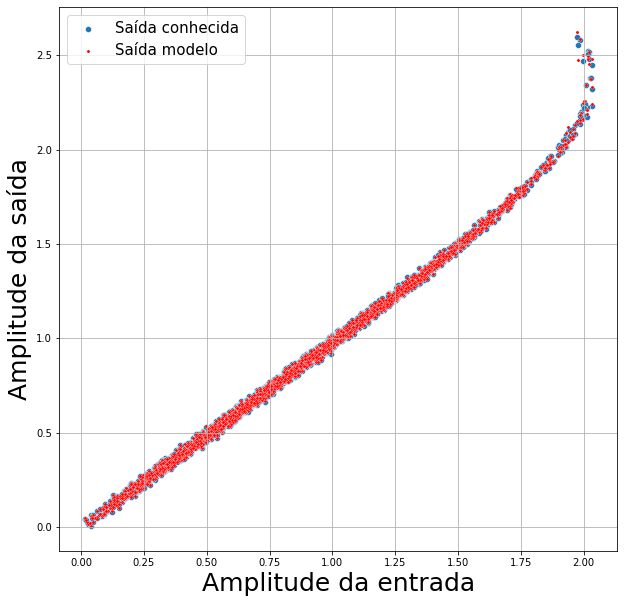

In [58]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 2] + 1j*data[:, 3]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model_Inv, x, y, M)
print(f'nmse - extração: {nmse}')

plt.figure(figsize=(10,10))
sns.scatterplot(x=x_abs, y=y_abs, label='Saída conhecida')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='Saída modelo', s=10, color='red')
plt.grid()
print(f'Extração - NMSE: {nmse:.3f}')
plt.legend(fontsize=15, loc='upper left')
plt.ylabel('Amplitude da saída', size=25)
plt.xlabel('Amplitude da entrada', size=25)
plt.savefig('fig/extracao_inversa.pdf', bbox_inches='tight')
plt.show()
plt.close()

### Inversa reduzida

In [23]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

M = 3
HL = 7

y = data[:, 0] + 1j*data[:, 1]
y = 0.7*normalize_data(y)
y_abs = np.abs(y)
print(y_abs.max())

x = run_model(y, model_PA, M)
x_abs = np.abs(x)

print(x_abs.max())

model_Inv, M, y_hat, nmse, his = find_best_M_HL(x, y[M+1:], M_min=M, M_max=M, HL_min=HL, HL_max=HL)
print(f'nmse - extraction: {nmse}')

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

y = data[:, 0] + 1j*data[:, 1]
y = 0.7*normalize_data(y)
y_abs = np.abs(y)
print(y_abs.max())

x = run_model(y, model_PA, M)
x_abs = np.abs(x)

print(x_abs.max())

nmse, y_hat = validation(model_Inv, x, y[M+1:], M)
print(f'nmse - validation: {nmse}')

1.8173348
1.7771702
*** BEST ***
Shape:10 M:3 HL:7 nmse:-59.02649402618408 time:198.70256066322327
nmse - extraction: -59.02649402618408
1.9674675
1.8780648
nmse - validation: -54.95192527770996


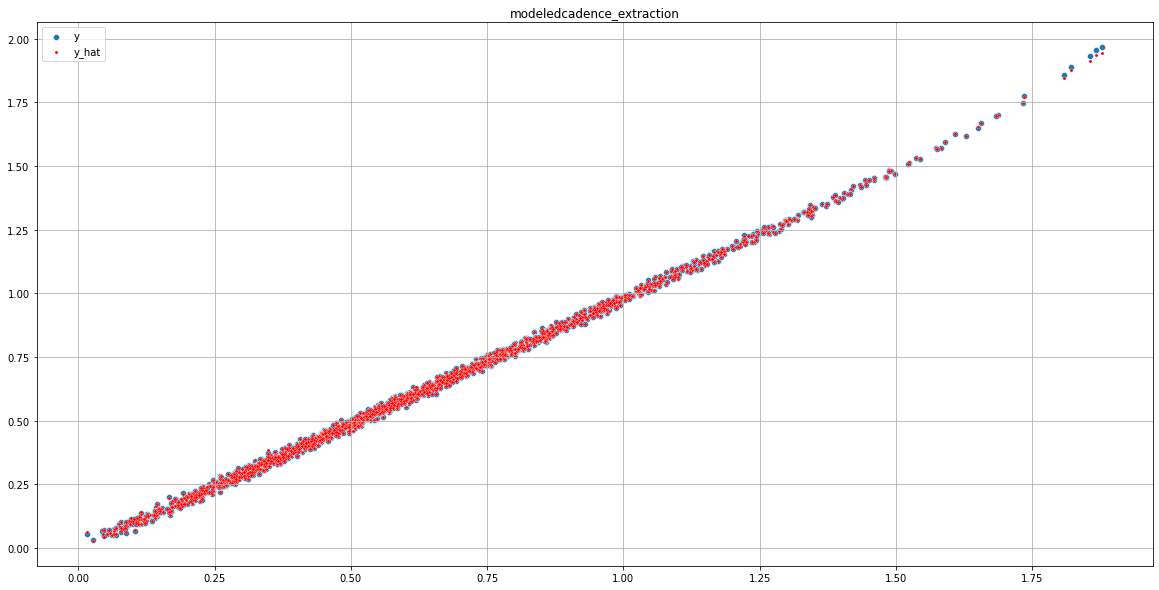

In [24]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=x_abs, y=y_abs, label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10, color='red')
plt.grid()
plt.title(f'Extração - NMSE: {nmse:.3f}')
plt.xlabel('Modulo da entrada')
plt.ylabel('Modulo da saida')
plt.show()
plt.close()

In [27]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

M = 3
HL = 7

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)
y_abs = np.abs(y)
print(y_abs.max())

x = run_model(y, model_PA, M)
x_abs = np.abs(x)

print(x_abs.max())

model_Inv, M, y_hat, nmse, his = find_best_M_HL(x, y[M+1:], M_min=M, M_max=M, HL_min=HL, HL_max=HL)
print(f'nmse - extraction: {nmse}')

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)
y_abs = np.abs(y)
print(y_abs.max())

x = run_model(y, model_PA, M)
x_abs = np.abs(x)

print(x_abs.max())

nmse, y_hat = validation(model_Inv, x, y[M+1:], M)
print(f'nmse - validation: {nmse}')

2.5961926
2.0290694
*** BEST ***
Shape:10 M:3 HL:7 nmse:-40.88686943054199 time:143.36403131484985
nmse - extraction: -40.88686943054199
2.810668
2.0273118
nmse - validation: -26.54186487197876


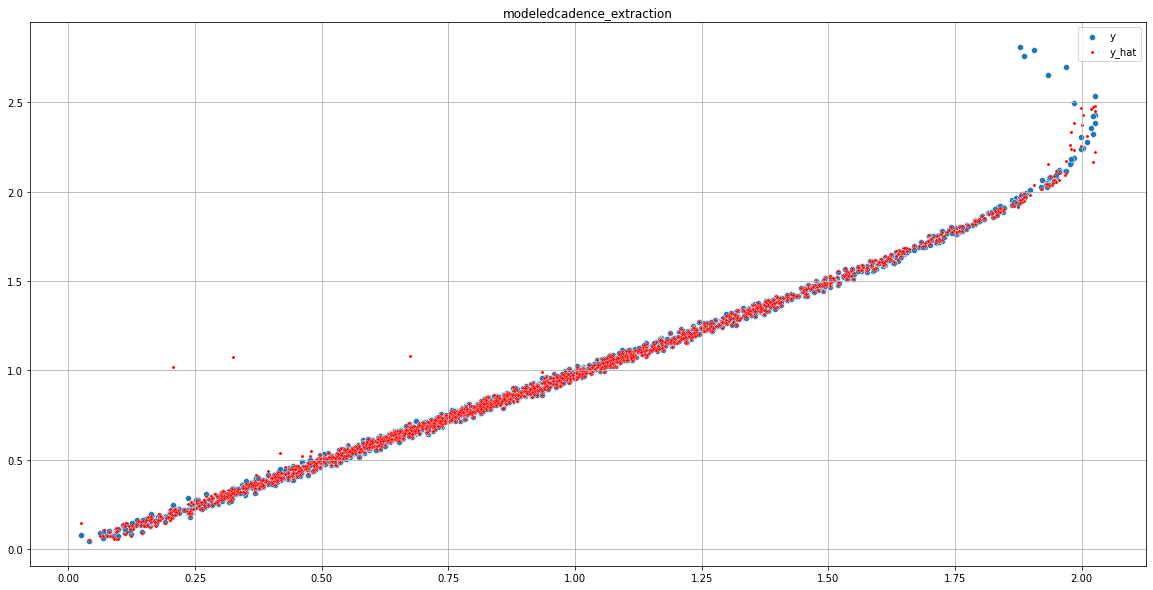

In [28]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs, y=y_abs[M+1:], label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10, color='red')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

## RNN

https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/

In [30]:
def prep_data_RNN(x, M0, M1):
    a0 = np.abs(x)
    abs = []
    for m in range(M0):
        abs.append(a0[M0+m+1-M0:m-M0])
    abs.append(a0[M0+1:])
    abs = np.array(abs).T

    p0 = np.angle(x)
    phase = []
    for m in range(M0):
        phase.append(p0[M0+m+1-M0:m-M0])
    phase.append(p0[M0+1:])
    phase = np.array(phase).T
    
    delta = []
    for m in range(1,phase.shape[1]):
        delta.append(phase[:,m]-phase[:,m-1])
    delta = np.array(delta).T
    
    d_cos = np.cos(delta)
    d_sin = np.sin(delta)

    inputs = abs
    if M0 > 0:
        inputs = np.append(inputs, d_cos, axis=1)
        inputs = np.append(inputs, d_sin, axis=1)
        
    samples = []
    for i in range(inputs.shape[0]):
        samples.append(inputs[i:i+M1])
    
    for i in range(1, M1):
        samples.pop()

    inputs = np.array(samples)
    return inputs

In [31]:
def gen_model_RNN(M0, M1, HL, name, activation='tanh'):
    size_input = 1+3*(M0)
    inputs = keras.Input(shape=(M1, size_input,))
    hidden = layers.GRU(HL, activation=activation)(inputs)
    output = layers.Dense(1, activation='linear')(hidden)
    model = keras.Model(inputs=inputs, outputs=output, name=name)
    model = lm.ModelWrapper(model)
    model.call = tf.function(model.call)
    return model

In [32]:
def find_best_M_HL_RNN(x, y, M_min=0, M_max=10, HL_min=1, HL_max=10):    
    best_M = 0
    best_model = None
    best_nmse = np.inf
    best_y_hat = None
    metaparams = product(range(M_min,M_max+1), range(HL_min,HL_max+1))
    for M, HL in metaparams:
        start = time()
        inputs = prep_data_RNN(x, M, M)
        print(inputs.shape)
        s_real, s_imag = gerar_s(y[2*M:], x[2*M:])

        model_real = gen_model_RNN(M, HL, 'parte_real')
        model_imag = gen_model_RNN(M, HL, 'parte_imag')

        compile_model(model_real)
        compile_model(model_imag)
        his = [0,0]
        his[0] = fit_model(model_real, 1000, inputs, s_real)
        his[1] = fit_model(model_imag, 1000, inputs, s_imag)

        model = (model_real, model_imag)
        # nmse = validation_models(model_real, model_imag, inputs, x, y)
        nmse, y_hat = validation(model, x, y, M)
        end = time()
        if nmse < best_nmse:
            best_nmse = nmse
            best_model = model
            best_M = M
            best_y_hat = y_hat
            print('*** BEST ***')
            print(f'Shape:{inputs.shape[1]} M:{M} HL:{HL} nmse:{nmse} time:{end-start}')
    return best_model, best_M, best_y_hat, best_nmse, his

In [33]:
def run_model_RNN(x, model, M0, M1):
    inputs = prep_data_RNN(x, M0, M1)    
    # Modificado por questões de performance, o model.predict acaba ficando sem o ganho de usar o tf.function no modelo
    s_hat_real = model[0](inputs).numpy().reshape(-1,)
    s_hat_imag = model[1](inputs).numpy().reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M0+M1:])
    return y_hat

In [34]:
def validation_RNN(model, x, y, M0, M1):
    y_hat = run_model_RNN(x, model, M0, M1)
    nmse = nmse_error(y[M0+M1:], y_hat)
    return nmse, y_hat

In [35]:
def run_RNN_M0_M1_HL(x, y, M0=0, M1=10, HL=1):
    start = time()
    inputs = prep_data_RNN(x, M0, M1)
    print(inputs.shape)
    s_real, s_imag = gerar_s(y[M0+M1:], x[M0+M1:])

    model_real = gen_model_RNN(M0, M1, HL, 'parte_real')
    model_imag = gen_model_RNN(M0, M1, HL, 'parte_imag')

    compile_model(model_real)
    compile_model(model_imag)
    his = [0,0]
    his[0] = fit_model(model_real, 100, inputs, s_real)
    his[1] = fit_model(model_imag, 100, inputs, s_imag)

    model = (model_real, model_imag)
    # nmse = validation_models(model_real, model_imag, inputs, x, y)
    nmse, _ = validation_RNN(model, x, y, M0, M1)
    end = time()
    print(f'Shape:{inputs.shape[1]} M0:{M0} M:{M1} HL:{HL} nmse:{nmse} time:{end-start}')
    return model, nmse, his

In [36]:
M0 = 1
M1 = 2
HL = 2

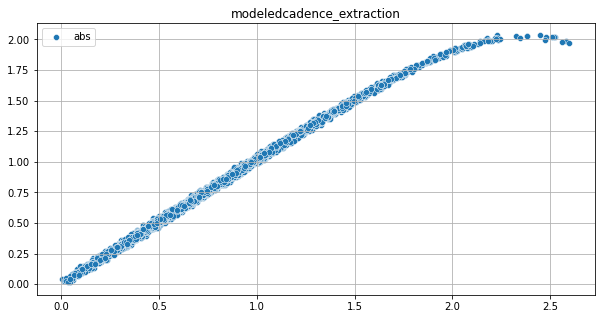

In [37]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

plt.figure(figsize=(10,5))
ax = sns.scatterplot(x=x_abs, y=y_abs, label='abs')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

In [38]:
model, nmse, his = run_RNN_M0_M1_HL(x, y, M0=M0, M1=M1, HL=HL)
print(f"nmse - extraction: {nmse}")

pv = p.parent / p.parts[-1].replace("extraction", "validation")
data = load_csv2numpy(pv)

x = data[:, 0] + 1j * data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j * data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, _ = validation_RNN(model, x, y, M0=1, M1=3)
print(f"nmse - validation: {nmse}")


(2995, 2, 4)
Shape:2 M0:1 M:2 HL:2 nmse:-51.31770610809326 time:317.07932209968567
nmse - extraction: -51.31770610809326


ValueError: Input 0 of layer "model_wrapper_6" is incompatible with the layer: expected shape=(None, 2, 4), found shape=(1994, 3, 4)

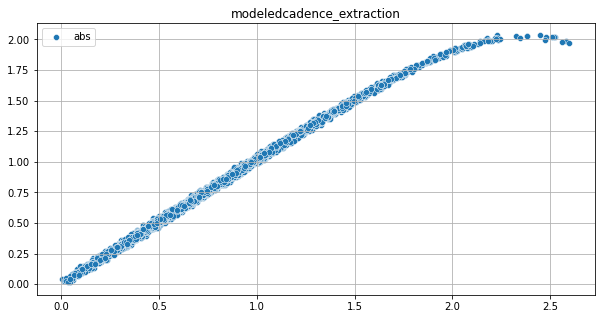

In [ ]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

plt.figure(figsize=(10,5))
ax = sns.scatterplot(x=x_abs, y=y_abs, label='abs')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

In [ ]:
x, y = y, x
model, nmse, his = run_RNN_M0_M1_HL(x, y, M0=1, M1=3, HL=4)
print(f"nmse - extraction: {nmse}")

pv = p.parent / p.parts[-1].replace("extraction", "validation")
data = load_csv2numpy(pv)

x = data[:, 0] + 1j * data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j * data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

x, y = y, x
nmse, _ = validation_RNN(model, x, y, M0=1, M1=3)
print(f"nmse - validation: {nmse}")


(2994, 3, 4)
Shape:3 M0:1 M:3 HL:4 nmse:-44.24376964569092 time:472.2574164867401
nmse - extraction: -44.24376964569092
nmse - validation: -27.248566150665283
